# Machine Translation

In [1]:
import re
import os
import numpy as np
import jieba
import collections

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [2]:
# Verify  GPU
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6000815871922697472
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15862523495
locality {
  bus_id: 2
  numa_node: 1
  links {
  }
}
incarnation: 9956778126131508898
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:87:00.0, compute capability: 6.0"
]


## 1. Data Preparation
### 1.1 Load Data

In [3]:
# Load English data
print("Loading data...")

def load_data(path):
    """
    Load dataset
    """
    input_file = os.path.join(path)
    with open(input_file, "r") as f:
        data = f.read()

    return data.split('\n')

en_sentences = load_data('data/train.txt.en')

# Load Chinese data
cn_sentences = load_data('data/train.txt.zh')

Loading data...


In [4]:
print('Dataset Loaded')
print("lenght of Source sentences:", len(en_sentences))
print("Source sample: ", en_sentences[0])

print("lenght of Target sentences:", len(en_sentences))
print("Target sample: ", cn_sentences[0].replace(" ",""))

Dataset Loaded
lenght of Source sentences: 209941
Source sample:  This is Bill Lange . I 'm Dave Gallo .
lenght of Target sentences: 209941
Target sample:  大卫.盖罗：这位是比尔.兰格，我是大卫.盖罗。


### 1.2 Filter out sentences with length more than 50

In [5]:
en_list = []
cn_list = []

#===========input parameter ========================
max_len = 50
#max_vocab_size = 50000
en_vocab_size = 50000 
cn_vocab_size = 10000
max_rows = 200000
#===================================================

def clean_eng(x):
    x = x.lower()
    x = re.sub('[!?]','',x)
    return x

def clean_chn(x):
    x = re.sub('[!?！？\n]','',x)
    x = jieba.cut(x)
    return ' '.join(x)

In [6]:
for i in range(len(en_sentences)):
    # Add <s> start and <e> end to the each target sentence  
    en_sentences[i] = clean_eng(en_sentences[i])
    cn_sentences[i] = "<s> " + clean_chn(cn_sentences[i].replace(" ","")) + " <e>"
    
    if len(en_sentences[i].split()) <= max_len and len(cn_sentences[i].split()) <= max_len:
        en_list.append(en_sentences[i])
        cn_list.append(cn_sentences[i])
        
print("lenght of Source:", len(en_list))
print("Source: ", en_list[0])

print("lenght of Target sentences:", len(cn_list))
print("Target: ", cn_list[0])

Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
Loading model cost 1.101 seconds.
Prefix dict has been built succesfully.


lenght of Source: 200884
Source:  this is bill lange . i 'm dave gallo .
lenght of Target sentences: 200884
Target:  <s> 大卫 . 盖罗 ： 这位 是 比尔 . 兰格 ， 我 是 大卫 . 盖罗 。 <e>


In [7]:
for i in range(5):
    print(en_list[i])
    print(cn_list[i])

this is bill lange . i 'm dave gallo .
<s> 大卫 . 盖罗 ： 这位 是 比尔 . 兰格 ， 我 是 大卫 . 盖罗 。 <e>
and we 're going to tell you some stories from the sea here in video .
<s> 我们 将 用 一些 影片 来 讲述 一些 深海 里 的 故事 。 <e>
we 've got some of the most incredible video of titanic that 's ever been seen , and we 're not going to show you any of it .
<s> 我们 这有 不少 精彩 的 泰坦尼克 的 影片 ， 可惜 您 今天 看不到 。 <e>
the truth of the matter is that the titanic -- even though it 's breaking all sorts of box office records -- it 's not the most exciting story from the sea .
<s> 泰坦尼克号 是 拿 了 不少 票房 冠军 但 事实上 它 并 不是 关于 海洋 的 最 刺激 的 故事 。 <e>
and the problem , i think , is that we take the ocean for granted .
<s> 原因 在于 我们 一直 没 把 海洋 当 回事儿 。 <e>


### 1.3 Split sentence into words

In [8]:
en_words_counter = collections.Counter([word for sentence in en_list for word in sentence.split()])
cn_words_counter = collections.Counter([word for sentence in cn_list for word in sentence.split()])

print('{} English words.'.format(len([word for sentence in en_sentences for word in sentence.split()])))
print('{} unique English words.'.format(len(en_words_counter)))
print('20 Most common words in the English dataset:')
print('"' + '" "'.join(list(zip(*en_words_counter.most_common(20)))[0]) + '"')
print("---------------------------------------------------------------------------------------------------------------")
print('{} Chinese words.'.format(len([word for sentence in cn_sentences for word in sentence.split()])))
print('{} unique Chinese words.'.format(len(cn_words_counter)))
print('20 Most common words in the Chinese dataset:')
print('"' + '" "'.join(list(zip(*cn_words_counter.most_common(20)))[0]) + '"')

4250820 English words.
55163 unique English words.
20 Most common words in the English dataset:
"," "." "the" "and" "to" "of" "a" "that" "i" "it" "in" "you" "we" "is" "'s" "this" "so" """ "they" "was"
---------------------------------------------------------------------------------------------------------------
4180600 Chinese words.
82572 unique Chinese words.
20 Most common words in the Chinese dataset:
"的" "<s>" "<e>" "，" "。" "我" "我们" "是" "在" "了" "你" """ "一个" "这" "有" "他们" "和" "就" "它" "这个"


### 1.4 Split data into training and testing set

In [9]:
### Split the preccessed data into training and test sets using Sklearn ###
en_train, en_test, cn_train, cn_test = train_test_split(np.array(en_list), 
                                                        np.array(cn_list), 
                                                        test_size=0.1, 
                                                        random_state=42,
                                                        shuffle = True)

In [10]:
print("en_train.shape: ", en_train.shape)
print("en_test.shape: ", en_test.shape)
print("cn_train.shape: ", cn_train.shape)
print("cn_test.shape: ", cn_test.shape)

en_train.shape:  (180795,)
en_test.shape:  (20089,)
cn_train.shape:  (180795,)
cn_test.shape:  (20089,)


## 2. Tokenize and Padding

### 2.1 Tokenize English and Chinese sentences

In [11]:
def tokenize(texts, maxlen, num_words):
    tokenizer = Tokenizer(filters='',num_words = num_words, oov_token = '<unk>')
    tokenizer.fit_on_texts(texts)
    vocab_size = len(tokenizer.index_word) + 1
    max_len = max(list(map(lambda i: len(i.split()), texts)))
    max_len =  min(max_len, maxlen)
    vocab_size = min(vocab_size, num_words)

    seqs = tokenizer.texts_to_sequences(texts)
    padded_seqs = pad_sequences(seqs, max_len, padding='post')
    return tokenizer, vocab_size, max_len, padded_seqs

In [12]:
# Create English tokeninzer for training set
src_tokenizer, src_vocab_size, src_max_len, en_input_seq = \
tokenize(en_train, max_len, en_vocab_size)

In [13]:
print("src_tokenizer.index_word: ", len(src_tokenizer.index_word))
print("src_vocab_size: ", src_vocab_size)
print("src_max_len: ", src_max_len)
print("en_input_seq.shape: ", en_input_seq.shape)
print("en_input_seq: ", en_input_seq)

src_tokenizer.index_word:  52939
src_vocab_size:  50000
src_max_len:  50
en_input_seq.shape:  (180795, 50)
en_input_seq:  [[   5    8  132 ...    0    0    0]
 [  10  222   11 ...    0    0    0]
 [ 340    2   14 ...    0    0    0]
 ...
 [  48 3818    9 ...    3    0    0]
 [   5   17   15 ...    0    0    0]
 [  26   35   20 ...    0    0    0]]


In [14]:
# Create Chinese tokeninzer
tar_tokenizer, tar_vocab_size, tar_max_len, de_input_seq = \
tokenize(cn_train, max_len, cn_vocab_size)

In [15]:
print("tar_tokenizer length: ", len(tar_tokenizer.index_word))
print("tar_tokenizer.index_word: ", tar_tokenizer.index_word[10])
print("tar_vocab_size: ", tar_vocab_size)
print("tar_max_len: ", tar_max_len)
print("de_input_seq.shape: ", de_input_seq.shape)
print("de_input_seq: ", de_input_seq) 

tar_tokenizer length:  78590
tar_tokenizer.index_word:  在
tar_vocab_size:  10000
tar_max_len:  50
de_input_seq.shape:  (180795, 50)
de_input_seq:  [[   3  102  878 ...    0    0    0]
 [   3    7   10 ...    4    0    0]
 [   3  658  133 ...    0    0    0]
 ...
 [   3   24  108 ... 1243    6    4]
 [   3   15   25 ...    0    0    0]
 [   3   40   66 ...    0    0    0]]


In [16]:
print(tar_tokenizer.index_word[12])

你


In [17]:
de_target_seq = de_input_seq[:,1:]
print("de_target_seq.shape: ", de_target_seq.shape)
print("de_target_seq: ", de_target_seq)

de_target_seq.shape:  (180795, 49)
de_target_seq:  [[ 102  878   22 ...    0    0    0]
 [   7   10  212 ...    4    0    0]
 [ 658  133   35 ...    0    0    0]
 ...
 [  24  108 3411 ... 1243    6    4]
 [  15   25  277 ...    0    0    0]
 [  40   66   68 ...    0    0    0]]


In [18]:
de_input_seq = de_input_seq[:,:-1]

print("de_input_seq.shape: ", de_input_seq.shape)
print("de_input_seq: ", de_input_seq)

de_input_seq.shape:  (180795, 49)
de_input_seq:  [[   3  102  878 ...    0    0    0]
 [   3    7   10 ...   13    4    0]
 [   3  658  133 ...    0    0    0]
 ...
 [   3   24  108 ...  294 1243    6]
 [   3   15   25 ...    0    0    0]
 [   3   40   66 ...    0    0    0]]


In [19]:
print('max len: ' + str((src_max_len, tar_max_len)))
print('vocab size: ' + str((src_vocab_size, tar_vocab_size)))

max len: (50, 50)
vocab size: (50000, 10000)


In [20]:
print(de_target_seq.shape)
print(tar_vocab_size)

del en_sentences
del cn_sentences

(180795, 49)
10000


In [21]:
de_target_matrix = to_categorical(de_target_seq, tar_vocab_size)

In [22]:
print(de_target_matrix.shape)

(180795, 49, 10000)


## 3. Callback Functions

### 3.1 Reduce learning rate when a metric has stopped improving
Now, we start defining callback functions...

In [23]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss', 
                               factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=2, 
                               min_lr=1e-6)

### 3.2 Model checkpoint

In [24]:
save_dir = os.getcwd()
weight_path = './weight/lstm.h5'

# model.save(model_path)
print('Model Path at %s ' % weight_path)

# Save the model after every epoch if model improves
model_checkpoint = ModelCheckpoint(weight_path, 
                                   monitor="val_acc", 
                                   save_best_only=True,
                                   save_weights_only=True, 
                                   verbose=1)

Model Path at ./weight/lstm.h5 


### 3.3 Early Stop

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=4, 
                               verbose=1)

### 3.4 Monitor Learning Rate for every epoch

In [26]:
history_lr = []  # Variable to store leraning rate history

class MonitorLR(tf.keras.callbacks.Callback):   
    def on_epoch_end(self, epoch, logs=None):
        print("\n")
        print("Learning Rate:", K.eval(self.model.optimizer.lr))
        print("\n")
        history_lr.append(K.eval(self.model.optimizer.lr))
              
monitorLR = MonitorLR()

### 3.5 Callback function
To be applied at given stages of the training procedure.

In [27]:
callbacks=[lr_reducer,
           monitorLR, 
           model_checkpoint,
           early_stopping]

## 4. Model
### 4.1 Build Model

In [28]:
print("Now, creating model...")
#======== model paramters =======
latent_dim = 1024
#======== train paramters =======
#epochs = 100
epochs = 30
batch_size = 128
#================================

Now, creating model...


### 4.2 Encoder model

In [29]:
print("Creating Encoder Model...")
enc_input = Input((None,), name = 'en_input_seq')
enc_embed = Embedding(src_vocab_size + 1, latent_dim, name = 'encoder_embed')
encoder = LSTM(latent_dim, return_state=True, name = 'encoder')

enc_z, enc_state_h, enc_state_c = encoder(enc_embed(enc_input))
enc_states = [enc_state_h, enc_state_c]
enc_model = Model(enc_input, enc_states)

print("enc_model: ", enc_model.summary())

Creating Encoder Model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
en_input_seq (InputLayer)    (None, None)              0         
_________________________________________________________________
encoder_embed (Embedding)    (None, None, 1024)        51201024  
_________________________________________________________________
encoder (LSTM)               [(None, 1024), (None, 102 8392704   
Total params: 59,593,728
Trainable params: 59,593,728
Non-trainable params: 0
_________________________________________________________________
enc_model:  None


### 4.3 Decoder model

In [30]:
print("Creating Decoder Model...")
dec_input = Input((None,), name = 'de_input_seq')
dec_state_h_input = Input((latent_dim,), name = 'decoder_input_state_h')
dec_state_c_input = Input((latent_dim,), name = 'decoder_input_state_c')
dec_states_input = [dec_state_h_input, dec_state_c_input]

dec_embed = Embedding(tar_vocab_size + 1, latent_dim, name = 'decoder_embed')
decoder = LSTM(latent_dim, return_state=True, return_sequences=True, name = 'decoder')
dec_fc = TimeDistributed(Dense(tar_vocab_size, activation='softmax'), name = 'decoder_output')

dec_z, dec_state_h, dec_state_c = decoder(dec_embed(dec_input), initial_state = dec_states_input)
dec_states_output = [dec_state_h, dec_state_c]
dec_output = dec_fc(dec_z)

dec_model = Model([dec_input]+dec_states_input, [dec_output]+dec_states_output)

print("dec_model: ", dec_model.summary())

Creating Decoder Model...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
de_input_seq (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
decoder_embed (Embedding)       (None, None, 1024)   10241024    de_input_seq[0][0]               
__________________________________________________________________________________________________
decoder_input_state_h (InputLay (None, 1024)         0                                            
__________________________________________________________________________________________________
decoder_input_state_c (InputLay (None, 1024)         0                                            
___________________________________________________________________________________

### 4.4 Encoder_decoder training model

In [31]:
print("Creating Encoder_decoder Model...")
tar_logit, _, _ = decoder(dec_embed(dec_input), initial_state= enc_states)
tar_output = dec_fc(tar_logit)

enc_dec_model = Model([enc_input, dec_input], tar_output)


if not os.path.exists('./weight/'):
    os.mkdir('./weight/')
    
try:
    enc_dec_model.load_weights(weight_path)
    print('load from previous model')
except:
    print('train a new model')    

optimizer = tf.keras.optimizers.Adam(lr = 0.001,
                                     beta_1=0.9, 
                                     beta_2=0.999, 
                                     amsgrad=False)

enc_dec_model.compile(loss = 'categorical_crossentropy',
                      optimizer= optimizer,
                      metrics=['accuracy'])

#  model summary
enc_dec_model.summary()

print("Done")

Creating Encoder_decoder Model...
train a new model
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
en_input_seq (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
de_input_seq (InputLayer)       (None, None)         0                                            
__________________________________________________________________________________________________
encoder_embed (Embedding)       (None, None, 1024)   51201024    en_input_seq[0][0]               
__________________________________________________________________________________________________
decoder_embed (Embedding)       (None, None, 1024)   10241024    de_input_seq[0][0]               
_________________________________________________________

### 4.5 Model Structure

In [32]:
# Save model as image
plot_model(enc_dec_model, 
           "./images/model.png", 
           show_shapes=True, 
           show_layer_names=True)

print("Done!")

Done!


Populating the interactive namespace from numpy and matplotlib


/root/miniconda3/envs/new/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['minimum', 'concatenate', 'multiply', 'subtract', 'maximum', 'dot', 'average', 'add']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


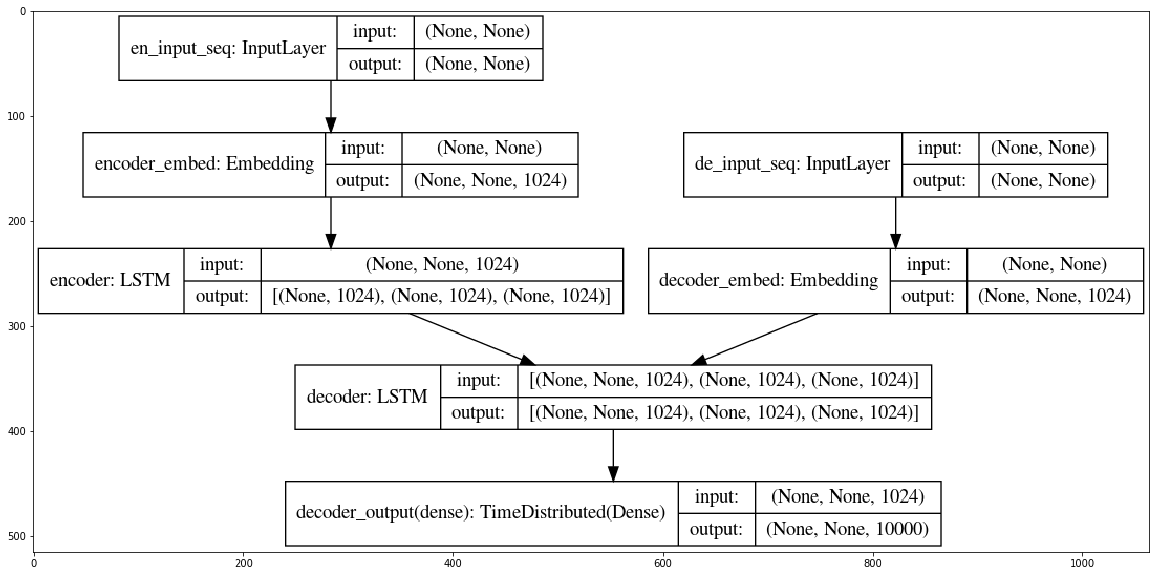

In [33]:
%pylab inline
import matplotlib.image as mpimg
img=mpimg.imread('./images/model.png')

plt.figure(figsize = (20,15))
imgplot = plt.imshow(img)
plt.show()

### 4.6 Fit Model

In [34]:
history = enc_dec_model.fit([en_input_seq, de_input_seq], 
                            de_target_matrix,
                            batch_size=batch_size,
                            epochs=epochs, 
                            shuffle = True,
                            callbacks = callbacks,
                            validation_split = 0.1)

/root/miniconda3/envs/new/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 162715 samples, validate on 18080 samples
Epoch 1/30
162688/162715 [============================>.] - ETA: 0s - loss: 1.9140 - acc: 0.7166

Learning Rate: 0.001



Epoch 00001: val_acc improved from -inf to 0.73637, saving model to ./weight/lstm.h5
162715/162715 [==============================] - 1006s 6ms/step - loss: 1.9139 - acc: 0.7166 - val_loss: 1.7036 - val_acc: 0.7364
Epoch 2/30
162688/162715 [============================>.] - ETA: 0s - loss: 1.5895 - acc: 0.7463

Learning Rate: 0.001



Epoch 00002: val_acc improved from 0.73637 to 0.74975, saving model to ./weight/lstm.h5
162715/162715 [==============================] - 880s 5ms/step - loss: 1.5895 - acc: 0.7463 - val_loss: 1.5297 - val_acc: 0.7497
Epoch 3/30
162688/162715 [============================>.] - ETA: 0s - loss: 1.4170 - acc: 0.7583

Learning Rate: 0.001



Epoch 00003: val_acc improved from 0.74975 to 0.75714, saving model to ./weight/lstm.h5
162715/162715 [==============================] - 877s 5ms/step 

## 5. Evaluate Model
### 5.1 Load Weight

In [35]:
print("Now, we start evaluating the model...")
# Load weight
print(weight_path)
enc_dec_model.load_weights(weight_path)
print("Weights were loaded!")

Now, we start evaluating the model...
./weight/lstm.h5
Weights were loaded!


### 5.2 Score training set

In [36]:
scores_train = enc_dec_model.evaluate([en_input_seq, de_input_seq], 
                                       de_target_matrix,
                                       verbose=1)

print('Train loss:', scores_train[0])
print('Train accuracy:', scores_train[1])

180795/180795 [==============================] - 851s 5ms/step
Train loss: 1.0656380515944006
Train accuracy: 0.7879474495812168


### 5.3 Score test data

In [37]:
# Tokenize and pad testing set
en_seqs = src_tokenizer.texts_to_sequences(en_test)
en_input_seq_test = pad_sequences(en_seqs, src_max_len, padding='post')

cn_seqs = tar_tokenizer.texts_to_sequences(cn_test)
de_input_seq_test = pad_sequences(cn_seqs, tar_max_len, padding='post')

de_target_seq_test = de_input_seq_test[:,1:]
de_input_seq_test = de_input_seq_test[:,:-1]

de_target_matrix_test = to_categorical(de_target_seq_test, tar_vocab_size)

In [38]:
print('en_input_seq_test.shape:', en_input_seq_test.shape)
print('de_input_seq_test.shape:', de_input_seq_test.shape)
print('de_target_seq_test.shape:', de_target_seq_test.shape)

en_input_seq_test.shape: (20089, 50)
de_input_seq_test.shape: (20089, 49)
de_target_seq_test.shape: (20089, 49)


In [39]:
scores_test = enc_dec_model.evaluate([en_input_seq_test, de_input_seq_test], 
                                     de_target_matrix_test,
                                     verbose=1)

print('Test loss:', scores_test[0])
print('Test accuracy:', scores_test[1])

20089/20089 [==============================] - 107s 5ms/step
Test loss: 1.335360285641098
Test accuracy: 0.7647468743409018


### 5.4 Accuracy and Loss Trend

Now, we start drawing the loss and acc trends graph...


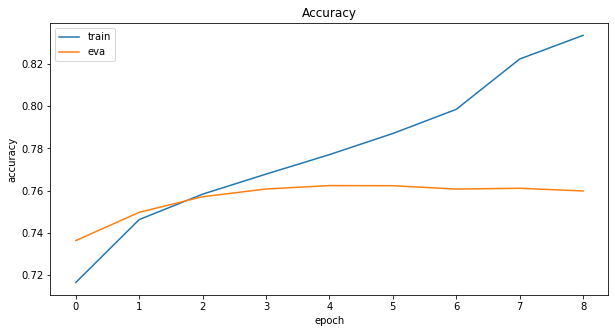

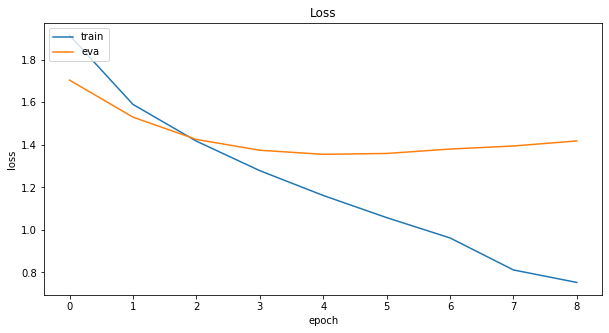

In [40]:
print("Now, we start drawing the loss and acc trends graph...")  
    
# Summarize history for accuracy 
fig = plt.figure(figsize=(10,5))
plt.plot(history.history["acc"])  
plt.plot(history.history["val_acc"])  
plt.title("Accuracy")  
plt.ylabel("accuracy")  
plt.xlabel("epoch")  
plt.legend(["train","eva"],loc="upper left")  
plt.show()
    
# Summarize history for loss
fig = plt.figure(figsize=(10,5))     
plt.plot(history.history["loss"])  
plt.plot(history.history["val_loss"])  
plt.title("Loss")  
plt.ylabel("loss")  
plt.xlabel("epoch")  
plt.legend(["train","eva"],loc="upper left")  
plt.show()

### 5.5 Learning Rate

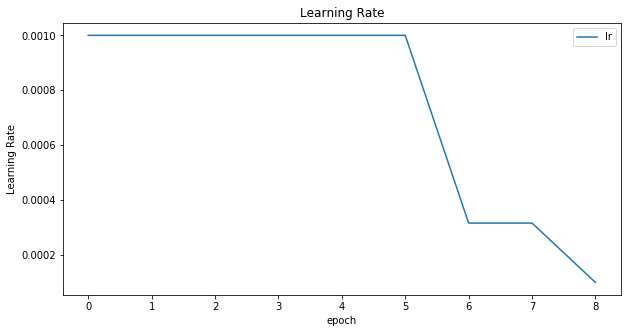

In [41]:
#summarize history for Learning rate
fig = plt.figure(figsize=(10,5))     
plt.plot(history_lr, label="lr")
plt.title("Learning Rate")  
plt.ylabel("Learning Rate")  
plt.xlabel("epoch")  
plt.legend()  
plt.show()


## 6. Translate Samples

In [42]:
import pandas as pd
df = pd.read_csv('./data/cmn.txt',sep='\t', header=None, names = ['en','cn'])
df.head()

,en,cn
0,Hi.,嗨。
1,Hi.,你好。
2,Run.,你用跑的。
3,Wait!,等等！
4,Hello!,你好。


In [43]:
def _init_states(enc_model, src_sentence, tokenizers, src_max_len):
    """generate the states from encoder
    Args:
        enc_model
        src_sentence
        tokenizers: tuple (src_tokenizer, tar_tokenizer)
        src_max_len
    Return:
        tuple (target_triple, initial_states)
    """
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_token = '<s>'
    tar_index = tar_word_index.get(tar_token, None)
    if tar_index == None:
        print('start token <s> not found!')
    src_input_seq = src_tokenizer.texts_to_sequences([src_sentence])
    src_input_seq = pad_sequences(src_input_seq, maxlen=src_max_len, padding='post')
    states = enc_model.predict(src_input_seq)
    return ([tar_index], [tar_token], [1.0]), states

In [44]:
def _update_states(dec_model, tar_triple, states, tokenizers):
    """ update the decoder states
    Args:
        dec_model
        tar_triple: (target index[list], target_token[list], target_probability[list])
        states:
        params:
    Return:
        tuple (tar_triple, states)
    """
    src_tokenizer, tar_tokenizer = tokenizers
    src_index_word = src_tokenizer.index_word
    src_word_index = src_tokenizer.word_index 
    tar_index_word = tar_tokenizer.index_word
    tar_word_index = tar_tokenizer.word_index
    tar_index, tar_token, tar_prob = tar_triple
    # predict the token probability, and states
    probs, state_h, state_c = dec_model.predict([[tar_index[-1]]] + states)
    states_new = [state_h, state_c]
    # update the triple
    # greedy search: each time find the most likely token (last position in the sequence)
    probs = probs[0,-1,:]
    tar_index_new = np.argmax(probs)
    tar_token_new = tar_index_word.get(tar_index_new, None)
    tar_prob_new = probs[tar_index_new]
    tar_triple_new = ( 
        tar_index + [tar_index_new],
        tar_token + [tar_token_new],
        tar_prob + [tar_prob_new]
        )
    return tar_triple_new, states_new

In [45]:
def infer_lstm(src_sentence, enc_model, dec_model, tokenizers, max_len = (9,14)):
    """infer the seq2seq model
    Args:
        src_sentence
        enc_model
        dec_model
        tokenizers,
        max_len
    Return:
        decoded sentence
    """
    src_max_len, tar_max_len = max_len
    # initialize with encoder states
    tr, ss = _init_states(enc_model, src_sentence, tokenizers, src_max_len)
    for i in range(tar_max_len):
        # update the triple and states
        tr, ss = _update_states(dec_model, tr, ss, tokenizers)
        if tr[1][-1] == '<e>' or tr[1][-1] == None:
            break
     
    return ''.join(tr[1])

In [46]:
for i in range(100,710):
    src_raw = en_test[i]
    #src_raw = df.en.values[i]
    src = clean_eng(src_raw)
    #print("src:", src)
    #src = "And we really have this incredibly simplistic view of why people work and what the labor market looks like."
    dec = infer_lstm(src, enc_model, dec_model, (src_tokenizer, tar_tokenizer),(50,49))
    print('[%s] => [%s]'%(src,dec))
    print("")

[and if you look at the 36 countries with the highest burden of malnutrition , that 's 260 billion lost from a productive economy every year .] => [<s>如果你看看这个<unk>的<unk>，每年会有<unk>亿人口，每年都会增加<unk>的<unk>。<e>]

[so if you don 't have an endgame of something delightful , then you 're just moving chess pieces around , if you don 't know you 're taking the king .] => [<s>所以如果你不知道你的<unk>，你会得到一个<unk>的<unk>，你会<unk>，你会<unk>。<e>]

[i was still in deep grief ; i knew i didn 't have the strength .] => [<s>我<unk><unk>，我知道我不知道我的<unk>。<e>]

[so why do we need commitment devices ] => [<s>那么为什么我们需要<unk>呢<e>]

[but this is not just about students sitting alone in their living room working through problems .] => [<s>但这不是在<unk>大学<unk>大学的学生。<e>]

[we actually have a couple of other planets in this solar system .] => [<s>事实上我们有了行星上的行星数量。<e>]

[they don 't like that . they think it 's crank . i don 't think it 's crank .] => [<s>他们觉得他们不觉得。我认为这是个<unk>。<e>]

[my own interest in this subject , and my passion for 

[you think , " what can i add to the system to create more value  "] => [<s>你想，"我想把它当作一个<unk>系统来实现"<e>]

[one : curved tips can maximize the springiness when you draw and shoot the arrow .] => [<s><unk>：<unk><unk><unk><unk><unk><unk><unk>。<e>]

[and he walked in , and somebody said something to him , we realized he was deaf , and we looked into the rags , and there was this pair of eyes .] => [<s>他<unk>了，然后他看着我，说，"我们把它<unk>，然后我们就把它<unk>了。<e>]

[actually , reduce your amount of light exposure at least half an hour before you go to bed .] => [<s>事实上，在你的<unk>里，你可以在<unk>的时间内<unk><unk>。<e>]

[they kind of have a sixth sense like superman 's x-ray vision .] => [<s>他们喜欢<unk><unk>的<unk><unk>。<e>]

[you don 't punish failure . you reward every little bit of effort -- a little bit of gold , a little bit of credit . you 've done 20 questions -- tick .] => [<s>你不需要<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，你就会有一些<unk>的<unk>。<e>]

[what we actually want to do is we want to take your email and turn i

[it was very obvious , from the very beginning , that she was a leader .] => [<s>从她身上的是，这不仅是一个<unk>的<unk>。<e>]

[well , you get several things .] => [<s>好了，你会得到一些东西。<e>]

[and by the end of this my arm is sore , i 've got a callus on my hand , let alone bob , whose rear end looks something more like this , like swiss cheese .] => [<s>在我<unk>的<unk>里，我的<unk><unk>了，<unk>了，<unk>了，<unk>了，我们<unk>了，<unk>了，<e>]

[and they start to see others doing it , and saying , " wow , i want to do that with my own money . "] => [<s>然后他们开始<unk>我的<unk>，说："我想，"我想买的是什么。"<e>]

[you 've got to say that 's not enough today .] => [<s>你要说，这不是今天的。<e>]

[she was taken away by authorities and placed in a psychiatric hospital , and so for the next several years will lived with his older brother until he committed suicide by shooting himself through the heart .] => [<s>她<unk>了<unk>，<unk>了<unk>，他在<unk>年去世，在他的<unk>里，他在<unk><unk>了<unk>，在<unk><unk>监狱里。<e>]

[and the chance that some of it isn 't more intelligent than ours 

[this is fairly recent science that has shown that .] => [<s>这是最近的研究显示了这个惊人的科学<e>]

[lucas again , in 1876 , showed us - 1 , 21 digits long , was not prime .] => [<s><unk>，<unk>，<unk>，<unk>，<unk>，我们<unk>了一下。<e>]

[but one time it broke down .] => [<s>但<unk>了，它就会<unk>。<e>]

[printing press took a century to be adopted ; the first computers were designed pen-on-paper -- now we use computers .] => [<s><unk>发明了一个<unk>，在<unk><unk>，我们可以用计算机来完成。<e>]

[but what if this wasn 't the first time ] => [<s>但如果不是第一个时间<e>]

[and on the other side , some african-americans dismissed or ignored homophobia that was indeed real in our community .] => [<s>在一些其他的穆斯林，<unk>的穆斯林，<unk>的穆斯林，都是<unk>的。<e>]

[this technological revolution is as inspiring and transformational as anything we have ever seen .] => [<s>这个革命的革命已经改变了我们的历史，也是我们所见到的。<e>]

[and , you see , this era coincided with my own childhood .] => [<s>你知道，我的童年经历了一场<unk>。<e>]

[and you can 't see this very well on the screen , but arduino -- arduino is an

[it started out with an article in red herring .] => [<s>它的<unk>是关于<unk>的<unk>。<e>]

[so to start , i want to introduce some characters from a book i made for teenagers .] => [<s>首先，我想让我来谈谈<unk>的<unk>。<e>]

[it turns out people think when they win the lottery their lives are going to be amazing .] => [<s>人们认为当他们<unk>的时候，他们的生活会被<unk>。<e>]

[and we now have 1,400 volunteers on our roster .] => [<s>现在我们有<unk><unk>公司，<e>]

[you might take states like iowa and ohio -- two very important political states , by the way -- those two governors , and they would say , we 're going to lead the nation in producing the wind turbines and the wind energy .] => [<s>你可以<unk><unk>和<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，我们需要解决的问题，<e>]

[it 's that you can see the world as it isn 't .] => [<s>这就是你能看到的世界的<unk>。<e>]

[if you want to talk about it , you know , i will listen to you through .] => [<s>如果你想听你，我想听你说的话。<e>]

[there 's the nest entrance , there 's a pencil for scale .] => [<s>这是一

[effectively you would have something like this .] => [<s>你就像这样的东西。<e>]

[this is odysseus as an old man who wants nothing more than to retire in a sunny villa with his wife penelope outside of ithaca -- the other one .] => [<s>这是个<unk><unk>的<unk>，我的父亲<unk><unk>，<unk><unk><unk>，<unk><unk><unk>。<e>]

[and then i 'm going to attempt onscreen animation here .] => [<s>接下来我要展示的是<unk>的<unk>。<e>]

[then he starts going up , and the next thing i hear is , " i 'm half-way up . it 's like climbing stairs . i 'm going up 60 degrees .] => [<s>他接着<unk>，我就说："我的<unk>，我的<unk><unk>了，我就<unk>了。<e>]

[are the basics of writing learning how to sharpen a quill ] => [<s>它是通过<unk>来学习如何<unk>的<e>]

[of course there 's health consequences to this , scary ones , besides the waist .] => [<s>当然，这也有很多影响，这些都是<unk>的，但这也是<unk>的。<e>]

[and that 's where i think organizations like ted , like the extreme ice survey can have a terrific impact on human perception and bring us along .] => [<s>这就是我认为，像这样的例子，我们可以从<unk>的角度来思考，比

[all right , here we go .] => [<s>好了，我们来看看。<e>]

[that 's because our ability to confront the problems that we face has not kept pace with our ability to create them .] => [<s>这是因为我们的<unk>和我们的<unk>并不<unk>我们的生活方式。<e>]

[this is what one of those primary nodes looks like , and it 's like a sub station with power and bandwidth that can spread out over an area the size of seattle .] => [<s>这是一个<unk>的<unk>，它可以在<unk><unk><unk><unk><unk>。<e>]

[last june 1 , we launched . it was an exciting moment .] => [<s>去年夏天我们<unk>了，我们真的很激动。<e>]

[and to tell the next part of the story -- and this is looking out say 2100 and beyond .] => [<s>接下来的下一个故事，就是这个，然后就像<unk>一样，<e>]

[there was a school , ps 234 , that had been evacuated down at ground zero .] => [<s>那里有一个<unk>，在<unk>，<unk><unk>。<e>]

[the man was without legs and only with one arm .] => [<s><unk>没有<unk>，她就<unk>了。<e>]

[i have fought in wars , feared for my own survival , watched my cohorts die on beaches and woods that look and feel more real than

[you can think of these as neighborhoods , as distinctive as tribeca and the upper east side and inwood -- that these are the forest and the wetlands and the marine communities , the beaches .] => [<s>你可以把这些<unk>带到<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>，<unk>。<e>]

[i grew up not far from here in washington d.c.] => [<s>我在华盛顿特区也在<unk><e>]

[it 's like the land and the king they 're inseparable , they are one .] => [<s>像<unk>一样，他们喜欢<unk>。<e>]

[i found jewishdoc57 who 's incredibly good-looking , incredibly well-spoken , he had hiked mt . fuji , he had walked along the great wall .] => [<s>我发现了<unk>的<unk>，他的<unk><unk>了<unk>，<unk>了<unk>，他<unk>了。<e>]

[that all of you seem to remember iran after the islamic revolution .] => [<s>大家都记得<unk><unk>的故事，在我们的战争中。<e>]

[now think of the absurdity of this situation .] => [<s>现在想想这个问题的<unk>。<e>]

[what is it  is that jackson pollock  "] => [<s>这是个<unk><unk>的<unk><e>]

[and if you sit here long enough , it 'll float off the page i

[so , we know it works . what would the content be of these international standards ] => [<s>所以我们知道，这就是网络的基础。我们有谁在<unk>呢<e>]

[i had the opportunity to have a discussion with president mbeki , and one of the things that we talked about is , what is it that 's keeping this connectivity goal from moving ahead faster ] => [<s>我有一个机会去参加一个会议，我们应该对我们的经济发展有影响，然后我们就会把它变成现实，然后我们就应该去做。<e>]

[very soon , the same systems that we use today to bring music and entertainment and gps information into our vehicles are going to be used to create a smart vehicle network .] => [<s>同样的，我们的<unk>也将<unk>的<unk><unk>，我们的网络，和网络的<unk>，和<unk>的<unk>，我们的<unk>。<e>]

[we could have been done by lunch here .] => [<s>我们可以在家里<unk>。<e>]

[think about vibration control or great sneakers , for example .] => [<s>想想<unk>的<unk>，或者是<unk>的。<e>]

[it 's because of air quality .] => [<s>因为它的<unk>是<unk>的。<e>]

[" hail to the gods of america . "] => [<s>"<unk><unk><unk>"<e>]

[and the size of the bubble is the population .] => [<s>而

[even in north korea , i was an f student .] => [<s>即使在<unk>，我还是个学生。<e>]

[you are the individuals you are , and you have this kind of core .] => [<s>你是你的<unk>，你是这样的。<e>]

[now judy bonds is a coal miner 's daughter .] => [<s>现在<unk><unk>是一个<unk>的<unk>。<e>]

[you can 't see it , but it 's there . "] => [<s>你看不见它，但它确实是这样的。"<e>]

[i could have started anywhere in the sentence , and i could have made this entire thing .] => [<s>我可以从<unk>的角度出发，我就能做这样的事。<e>]

[now , folks often ask us at the james randi educational foundation , they call me , they say , " why are you so concerned about this , mr. randi ] => [<s>现在，他们<unk><unk><unk>，告诉我，你的<unk>，他们会说，"你在<unk>，我们会把这些<unk><unk>"<e>]

[so we didn 't just launch two of them like this , we launched 28 of them .] => [<s>所以我们就不把它们<unk>了，然后我们就把它<unk>了。<e>]

[the first lesson is about that design can change not just your product .] => [<s>第一个项目是这样的：改变设计的方式。<e>]

[why not  i think this is rather important .] => [<s>我为什么不觉得这很重要<e>]

[that was all a prel

In [47]:
print("Everything seems OK...")
print("Accomplished!")

Everything seems OK...
Accomplished!
